In [1]:
import os
import time
from datetime import datetime
import numpy as np
import pandas as pd
from sodapy import Socrata

apptoken = os.environ.get("SODAPY_APPTOKEN")
domain = "data.melbourne.vic.gov.au"
client = Socrata(domain, apptoken)

In [77]:
# function to get attributes of a column in the df about datasets
def dseries(df, col, attrib, attrib_sub=None, count=False):  
    ls = []
    if attrib_sub == None:
        for d in df[col]:
            if count:
                ls.append(len(d[attrib]))
            else:
                ls.append(d[attrib])
    else:
        for d in df[col]:
            if count:
                ls.append(len(d[attrib][attrib_sub]))
            else:
                ls.append(d[attrib][attrib_sub])
    return pd.Series(ls)

# function to make dataframe of interested info
def interesteddf(rdf):
    a = dseries(rdf, 'resource', 'name')
    b = dseries(rdf, 'resource', 'id')
    c = dseries(rdf, 'resource', 'parent_fxf')
    d = dseries(rdf, 'resource', 'description')
    e = dseries(rdf, 'resource', 'data_updated_at')
    f = dseries(rdf, 'resource', 'page_views', 'page_views_last_week')
    g = dseries(rdf, 'resource', 'page_views', 'page_views_last_month')
    h = dseries(rdf, 'resource', 'page_views', 'page_views_total')
    i = dseries(rdf, 'resource', 'download_count')
    j = dseries(rdf, 'classification', 'categories')
    k = dseries(rdf, 'classification', 'domain_category')
    l = dseries(rdf, 'classification', 'domain_tags')
    m = dseries(rdf, 'classification', 'domain_metadata')
#     n = dseries(rdf, 'resource', 'columns_name', True)  # count=True, not working yet

    col =  ['name', 'id', 'parent_fxf', 'description', 'data_upd_at', 'pv_last_wk', 'pv_last_mth', 'pv_total',
            'download_count', 'categories', 'domain_category', 'domain_tags', 'domain_metadata']
#             'no_cols']

    df = pd.concat([a,b,c,d,e,f,g,h,i,j,k,l,m], axis='columns')
    df.columns = col

    return df

# function to tokenise description and name columns
def tokenise2(df):
    # tokenize by [1] making all lower case [2] removing some unwanted stop characters [3] splitting string into list of word tokens

    df['description'] = df['description'].str.lower().str.replace(r'\. ', ' ').str.replace('\, ', ' ')
    df['description'] = df['description'].str.replace('– ',' ').str.replace('- ',' ').str.split()

    df['name'] = df['name'].str.replace('(','').str.replace(')','')
    df['name'] = df['name'].str.lower().str.replace(r'\. ', ' ').str.replace('\, ', ' ')
    df['name'] = df['name'].str.replace('– ',' ').str.replace('- ',' ').str.split()

    return df

In [73]:
rdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   resource           223 non-null    object
 1   classification     223 non-null    object
 2   metadata           223 non-null    object
 3   permalink          223 non-null    object
 4   link               223 non-null    object
 5   owner              223 non-null    object
 6   creator            223 non-null    object
 7   preview_image_url  39 non-null     object
dtypes: object(8)
memory usage: 14.1+ KB


In [50]:
rdf.resource[0]

{'name': 'Pedestrian Counting System - Monthly (counts per hour)',
 'id': 'b2ak-trbp',
 'parent_fxf': [],
 'description': 'This dataset contains hourly pedestrian counts since 2009 from pedestrian sensor devices located across the city. The data is updated on a monthly basis and can be used to determine variations in pedestrian activity throughout the day.\n<p>The sensor_id column can be used to merge the data with the <a href="https://data.melbourne.vic.gov.au/Transport-Movement/Pedestrian-Counting-System-Sensor-Locations/h57g-5234">Pedestrian Counting System - Sensor Locations</a> dataset which details the location, status and directional readings of sensors. Any changes to sensor locations are important to consider when analysing and interpreting pedestrian counts over time.\n<p><b>Importants notes about this dataset:</b>\n<br>•\tWhere no pedestrians have passed underneath a sensor during an hour, a count of zero will be shown for the sensor for that hour. \n<br>•\tDirectional readi

In [78]:
rds = client.datasets()
rdf = pd.DataFrame.from_dict(rds)

ds_df = interesteddf(rdf)
ds_df.head(2).T

,0,1
name,Pedestrian Counting System - Monthly (counts p...,Tree canopies 2011 (Urban Forest)
id,b2ak-trbp,y79a-us3f
parent_fxf,[],[]
description,This dataset contains hourly pedestrian counts...,Tree canopy within City of Melbourne mapped us...
data_upd_at,2021-09-06T01:54:59.000Z,None
pv_last_wk,266,28
pv_last_mth,1168,87
pv_total,72145,66804
download_count,8572,3178
categories,[finance],[environment]


In [70]:
ds_df["domain_category"].value_counts()

Environment     54
Transport       43
Business        40
City Council    30
Property        29
People          24
Events           3
Name: domain_category, dtype: int64

In [71]:
ds_df.groupby(by="domain_category")

In [4]:
ds_df_ratios = ds_df.copy()
ds_df_ratios["pv_wk_mth_ratio"] = ds_df["pv_last_wk"]/ds_df["pv_last_mth"]
ds_df_ratios["pv_dl_ratio"] = ds_df["pv_total"]/ds_df["download_count"]
ds_df_ratios = ds_df_ratios[["name","id","pv_wk_mth_ratio","pv_last_mth",
                             "pv_dl_ratio","download_count"]]
ds_df_ratios.head(15)

,name,id,pv_wk_mth_ratio,pv_last_mth,pv_dl_ratio,download_count
0,Pedestrian Counting System - Monthly (counts p...,b2ak-trbp,0.227740,1168,8.416356,8572
1,Tree canopies 2011 (Urban Forest),y79a-us3f,0.321839,87,21.020768,3178
2,"Trees, with species and dimensions (Urban Forest)",fp38-wiyy,0.231986,569,6.239732,6257
3,On-street Parking Bay Sensors,vh2v-4nfs,0.273333,750,0.003088,12080271
4,Pay Stay zones linked to street segments,7q9g-yyvg,0.280172,232,18.176914,1724
5,Median House Prices - By Type and Sale Year,i8px-csib,0.293432,944,8.856291,3187
6,On-street Parking Bays,crvt-b4kt,0.228916,498,0.610770,39776
7,"Cafes and restaurants, with seating capacity",xt2y-tnn9,0.350267,374,1.484135,16010
8,Development Activity Monitor,gh7s-qda8,0.324786,234,3.716661,6194
9,"Buildings with name, age, size, accessibility,...",pmhb-s6pn,0.260870,253,5.949482,3187


<AxesSubplot:ylabel='name'>

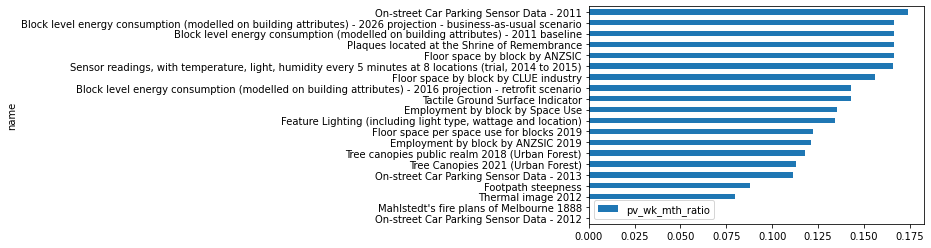

In [60]:
ds_df_ratios = ds_df_ratios.sort_values(by=["pv_wk_mth_ratio"], ascending=True)
ds_df_ratios.head(20).plot.barh(x="name",y="pv_wk_mth_ratio")

In [57]:
ds_df_ratios.head(20)

,name,id,pv_wk_mth_ratio,pv_last_mth,pv_dl_ratio,download_count
194,Tree canopies 2013,kv9p-crx6,0.818182,22,0.863636,594
209,Tree canopies 2014,7kjb-25ry,0.800000,10,0.343241,1043
128,Staff salary and wages budget 2014-15,55up-8nwa,0.666667,24,1.033333,1230
60,Fees and charges 2014-15,2eyd-p5ws,0.642857,14,1.183942,2740
132,House Prices by Small Area - Transfer Year,r6ug-jmg3,0.592593,27,0.959036,1245
180,Workers Profile 2016,rsgn-pgkc,0.590909,44,0.782130,817
151,Syringe bin locations,96gt-j9ix,0.588235,17,0.000417,2229339
96,Playgrounds,rwbd-626w,0.584071,113,0.001095,1726860
154,Employment and floor space forecasts by urban ...,rsje-n6de,0.583333,12,0.892000,1000
142,"Cafe, restaurant, bistro seats 2017 map",w2pi-36nk,0.583333,36,5.382979,188


In [5]:
ds_df_tok = tokenise2(ds_df)
ds_df_tok.head(2).T

/home/honalbert/.local/lib/python3.7/site-packages/ipykernel_launcher.py:40: FutureWarning: The default value of regex will change from True to False in a future version.
/home/honalbert/.local/lib/python3.7/site-packages/ipykernel_launcher.py:43: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
/home/honalbert/.local/lib/python3.7/site-packages/ipykernel_launcher.py:44: FutureWarning: The default value of regex will change from True to False in a future version.


,0,1
name,"[pedestrian, counting, system, monthly, counts...","[tree, canopies, 2011, urban, forest]"
id,b2ak-trbp,y79a-us3f
parent_fxf,[],[]
description,"[this, dataset, contains, hourly, pedestrian, ...","[tree, canopy, within, city, of, melbourne, ma..."
data_upd_at,2021-09-06T01:54:59.000Z,None
pv_last_wk,266,28
pv_last_mth,1168,87
pv_total,72145,66804
download_count,8572,3178
categories,[finance],[environment]


In [6]:
## 000 ## other interesting info
#
## columns of dataset
# rdf['resource'][0]['columns_name']
# rdf['resource'][0]['columns_field_name']
# rdf['resource'][0]['columns_datatype']
# rdf['resource'][0]['columns_description']
#

In [7]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   name             223 non-null    object
 1   id               223 non-null    object
 2   parent_fxf       223 non-null    object
 3   description      223 non-null    object
 4   data_upd_at      201 non-null    object
 5   pv_last_wk       223 non-null    int64 
 6   pv_last_mth      223 non-null    int64 
 7   pv_total         223 non-null    int64 
 8   download_count   223 non-null    int64 
 9   categories       223 non-null    object
 10  domain_category  223 non-null    object
 11  domain_tags      223 non-null    object
 12  domain_metadata  223 non-null    object
dtypes: int64(4), object(9)
memory usage: 22.8+ KB


In [8]:
ds_df['domain_metadata'][2]

[{'key': 'Quality_Known-Issues',
  'value': 'Date and year planted fields may have missing date values. '},
 {'key': "Quality_What's-included",
  'value': 'All data held by the City of Melbourne has been included'},
 {'key': 'Quality_Update-frequency', 'value': 'Daily'},
 {'key': 'Quality_Reliability-level', 'value': 'Reliable and timely'},
 {'key': 'Data-management_Source-data-update-frequency', 'value': 'Monthly'}]

In [9]:
for kv in ds_df['domain_metadata'][2]:
    print(kv['key'])

Quality_Known-Issues
Quality_What's-included
Quality_Update-frequency
Quality_Reliability-level
Data-management_Source-data-update-frequency


In [10]:
for kv in ds_df['domain_metadata'][0]:
    if kv['key']=='Quality_Update-frequency':
        print(f"[{kv['key']}] : {kv['value']}")
    if kv['key']=='Data-management_Source-data-update-frequency':
        print(f"[{kv['key']}] : {kv['value']}")

[Quality_Update-frequency] : Monthly
[Data-management_Source-data-update-frequency] : Hourly


In [11]:
keys = []
for record in ds_df['domain_metadata']:
    for kv in record:
        keys.append(kv['key'])
keys_ds = pd.Series(keys).drop_duplicates().reset_index(drop=True)

In [12]:
keys_ds

0                               Quality_What's-included
1                              Quality_Update-frequency
2                             Quality_Reliability-level
3                                  How-to-use_Linked-to
4          Data-management_Source-data-update-frequency
5                                  Quality_Known-Issues
6                        How-to-use_Further-information
7                  Quality_Source-data-update-frequency
8                        Quality_Data-quality-statement
9                Melbourne-Metadata_Further-Information
10                  Internal-management_IMGF-risk-level
11                 Internal-management_Update-mechanism
12    Internal-management_Source-system-(GIS,-AssetM...
13                 How-to-use_Applicable-standard-(URL)
dtype: object

In [13]:
df1 = ds_df.copy()
for key in keys_ds:
    df1[key] = np.nan
    for i in range(df1.shape[0]):
        for kv in df1['domain_metadata'][i]:
            if kv['key'] == key:
                df1[key][i] = kv['value']

/home/honalbert/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/honalbert/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [14]:
for qi in df1['Quality_Known-Issues'].unique():
    print(qi)

nan
Date and year planted fields may have missing date values. 
Parking Sensors are not operational on Public Holidays. Parking Sensors will show car parks as vacant when blocked by construction zones. 
None
No known issues
Note this dataset may not contain a reading for every sensor for every 15 minutes as the sensor devices might not have a reading for each value. There may be situations where no readings are reported for all sensors or only some readings are reported at a particular site. 
Dataset contains 'duration in minutes' field which differs from other parking sensor datasets which contain 'duration in seconds'.
Docks have since been removed after the end of the program in Nov 2019
Dataset contains 'duration in minutes' field which differs from other parking sensor datasets which contain 'duration in seconds'. Dataset was extracted from system so some active readings may not have been received from sensors towards the end of the dataset (May 26th). 
Listed branches will be dif

In [15]:
df1['Quality_Update-frequency'].unique()

array(['Monthly', 'Static (not updated)', 'Daily', '2 Minutes',
       'Quarterly', 'Annually', '15 Minutes', 'Every two years', 'Hourly'],
      dtype=object)

In [16]:
df1['Data-management_Source-data-update-frequency'].unique()

array(['Hourly', 'Monthly', 'Real-time', 'Annually', 'Daily', 'Weekly',
       'Static (not updated)', '15 Minutes', 'Every two years',
       'Quarterly'], dtype=object)

In [17]:
df1['Quality_Source-data-update-frequency'].unique()

array([nan, 'Daily', 'Monthly', 'Annually', 'Quarterly'], dtype=object)

In [18]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 27 columns):
 #   Column                                                     Non-Null Count  Dtype 
---  ------                                                     --------------  ----- 
 0   name                                                       223 non-null    object
 1   id                                                         223 non-null    object
 2   parent_fxf                                                 223 non-null    object
 3   description                                                223 non-null    object
 4   data_upd_at                                                201 non-null    object
 5   pv_last_wk                                                 223 non-null    int64 
 6   pv_last_mth                                                223 non-null    int64 
 7   pv_total                                                   223 non-null    int64 
 8   download_count      

In [19]:
# very wordy and different for each record
for qi in df1["Quality_What's-included"].unique():
    print(qi)

All data held by the City of Melbourne has been included
nan
All active sensor readings. Number of sensor readings may fluctuate as sensor connections connect/reconnect to the network. 
All surveyed parking bay data
Full dataset has been included
Data has been completed with information availible at the time of publish
All parking signs that have a relevant mapped parking bay.
All known major developments
All data has been included
XYZ points for buildings, terrain, vegetation (non classified) for the City of Melbourne area.
Some information has been removed due to contractual agreements with suppliers
Full dataset has been included.
This dataset has been confidentialised to protect the commercially sensitive information of individual businesses. Data in cells which pertain to two or fewer businesses have been suppressed and are shown as a blank cell. The row and column totals refer to the true total, including those suppressed cells.
These are indicators and in most cases City of Melb

In [20]:
df1['Quality_Reliability-level'].unique()

array(['Reliable and timely', 'Useful with caveats', nan], dtype=object)

In [21]:
for hl in df1['How-to-use_Linked-to'].unique():
    print(hl)

http://www.pedestrian.melbourne.vic.gov.au/
nan
Environmental Data - Assets, Environmental Data - GHG Factors
Road Corridor
http://cityofmelbourne.maps.arcgis.com/apps/MapSeries/index.html?appid=5c6bf1fc3f094e418e55eb1bce03953e
https://data.melbourne.vic.gov.au/Economy/Census-of-Land-Use-and-Employment-Blocks/aia8-ryiq
Environmental Data - Assets, Environmental Data - Billing Data
Environmental Data - Billing, Environmental Data - GHG Factors
https://data.melbourne.vic.gov.au/Economy/Census-Of-Land-Use-And-Employment-CLUE-Small-Areas/gei8-3w86
http://biodiversity.melbourne.vic.gov.au/insects/#/butterflies
https://data.melbourne.vic.gov.au/Economy/Employment-and-floor-space-forecasts-by-suburb/gb88-t7zc
N/A


In [22]:
df1["Quality_Update-frequency"].unique()

array(['Monthly', 'Static (not updated)', 'Daily', '2 Minutes',
       'Quarterly', 'Annually', '15 Minutes', 'Every two years', 'Hourly'],
      dtype=object)

In [23]:
df1['Data-management_Source-data-update-frequency'].unique()

array(['Hourly', 'Monthly', 'Real-time', 'Annually', 'Daily', 'Weekly',
       'Static (not updated)', '15 Minutes', 'Every two years',
       'Quarterly'], dtype=object)

In [24]:
df1['Quality_Source-data-update-frequency'].unique()

array([nan, 'Daily', 'Monthly', 'Annually', 'Quarterly'], dtype=object)

In [25]:
df1["name"]

0      [pedestrian, counting, system, monthly, counts...
1                  [tree, canopies, 2011, urban, forest]
2      [trees, with, species, and, dimensions, urban,...
3                     [on-street, parking, bay, sensors]
4       [pay, stay, zones, linked, to, street, segments]
                             ...                        
218    [social, indicators, for, city, of, melbourne,...
219    [commingled, recycling, collected, at, centre,...
220                [tree, canopies, 2021, urban, forest]
221    [commingled, recycling, collected, at, degrave...
222    [cardboard, bales, collected, at, degraves, st...
Name: name, Length: 223, dtype: object

In [26]:
df1[~df1['Quality_Source-data-update-frequency'].isnull()].T

,6,11,16,57,58,85,102
name,"[on-street, parking, bays]","[on-street, car, park, bay, restrictions]","[property, boundaries]","[on-street, car, parking, meters, with, location]","[public, toilets]","[building, information, 2017, map]","[melbourne, visitor, contact, stats]"
id,crvt-b4kt,ntht-5rk7,e56b-j9mj,vdsi-4gtj,ru3z-44we,be3i-empa,e63d-rbu7
parent_fxf,[],[],[],[],[],[pmhb-s6pn],[]
description,"[this, dataset, contains, spatial, polygons, w...","[each, row, contains, information, about, the,...","[this, details, the, boundaries, of, all, prop...","[this, dataset, shows, the, location, and, inf...","[public, toilets, known, about, or, operated, ...","[data, collected, as, part, of, the, city, of,...","[the, city, of, melbourne, provides, visitor, ..."
data_upd_at,2021-08-23T16:04:33.000Z,2021-09-14T16:04:00.000Z,2021-08-23T16:14:32.000Z,2021-09-03T16:01:41.000Z,2021-09-15T16:08:31.000Z,2020-09-11T00:20:26.000Z,2019-01-14T00:47:27.000Z
pv_last_wk,114,85,78,10,26,8,10
pv_last_mth,498,306,212,52,93,33,33
pv_total,24294,17337,12530,3408,3405,2138,1779
download_count,39776,566459,2212262,2354,2501,252,2714
categories,[transportation],"[transportation, recreation, economy]",[],[transportation],[],"[housing & development, demographics, transpor...","[demographics, infrastructure]"


In [27]:
for qs in df1["Quality_Data-quality-statement"].unique():
    print(qs,"\n")

nan 

This data contains all spatially mapped on-street car parking bays. There is a large number of bays which have not yet been mapped. Data has been collected from a number of years, there may be parking bays that no longer exist that still show in dataset. Users are advised to contact council using the email listed to report data errors.  

A team of 4 census officers conduct field interviews which involves visiting every establishment in every building in the Census area (City of Melbourne municipality). Every commercial property is surveyed at least once every two years. 

Building accessibility data is collected to track accessibility for internal City of Melbourne purposes. This data is provided as a community service by the City of Melbourne. It is not and does not purport to be a complete guide. There may be errors or omissions. Data is liable to change. The City of Melbourne accepts no responsibility in respect of any claim arising from use or reliance upon this data. 

Data

In [28]:
for mi in df1["Melbourne-Metadata_Further-Information"].unique():
    print(mi,"\n")

nan 

https://www.melbourne.vic.gov.au/CommunityServices/SocialSupport/Documents/Helping_Out_Booklet.pdf 



In [29]:
for ki in df1['Quality_Known-Issues'].unique():
    print(ki,"\n")

nan 

Date and year planted fields may have missing date values.  

Parking Sensors are not operational on Public Holidays. Parking Sensors will show car parks as vacant when blocked by construction zones.  

None 

No known issues 

Note this dataset may not contain a reading for every sensor for every 15 minutes as the sensor devices might not have a reading for each value. There may be situations where no readings are reported for all sensors or only some readings are reported at a particular site.  

Dataset contains 'duration in minutes' field which differs from other parking sensor datasets which contain 'duration in seconds'. 

Docks have since been removed after the end of the program in Nov 2019 

Dataset contains 'duration in minutes' field which differs from other parking sensor datasets which contain 'duration in seconds'. Dataset was extracted from system so some active readings may not have been received from sensors towards the end of the dataset (May 26th).  

Listed br

In [30]:
for hi in df1['How-to-use_Further-information'].unique():
    print(hi,"\n")

nan 

http://www.melbourne.vic.gov.au/parking-and-transport/parking/Pages/parking-faqs.aspx 

https://data.melbourne.vic.gov.au/api/views/gh7s-qda8/files/51e3db26-a063-4825-ae6c-1a40c0259c75?download=true&filename=DAM_-_Info_-_DAM_May_2016_Meta_Data_Info.pdf 

http://www.melbourne.vic.gov.au/clue 

Data is updated yearly (but refreshed overnight) 

http://www.melbourne.vic.gov.au/ParkingTransportandRoads/Parking/Pages/InGroundSensors.aspx 

To create a spatial dataset use the road_segment and the seg_id fields to join the two datasets 

http://www.melbourne.vic.gov.au/Sustainability/RooftopProject/Pages/Rooftop.aspx 

http://open.dataforcities.org/ 

Data will be availible for duration of Open Innovation Competition only.  

http://www.arborcarbon.com.au/ 

https://www.melbourne.vic.gov.au/CommunityServices/SocialSupport/Documents/Helping_Out_Booklet.pdf 

http://www.melbourne.vic.gov.au/AboutCouncil/financegovernance/Budget/Documents/Annual_Plan_Budget_Document_2014_2015.pdf 

http://

In [31]:
df1['Internal-management_IMGF-risk-level'].unique()

array([nan, 'Low risk'], dtype=object)

In [32]:
df1['Internal-management_IMGF-risk-level'].isnull().sum()

222

In [33]:
df1['Internal-management_Update-mechanism'].unique()

array([nan, 'Scheduled FME job'], dtype=object)

In [34]:
df1['Internal-management_Update-mechanism'].isnull().sum()

222

In [35]:
df1['How-to-use_Applicable-standard-(URL)'].unique()

array([nan, 'http://www.abs.gov.au/ausstats/abs@.nsf/mf/1292.0',
       'http://standards.opencouncildata.org/#/dogzones'], dtype=object)

In [36]:
df1['How-to-use_Applicable-standard-(URL)'].isnull().sum()

221

In [37]:
# disinterested domain_metadata
dis = ['How-to-use_Applicable-standard-(URL)',\
       'Internal-management_Source-system-(GIS,-AssetMaster,-etc)',
       'Internal-management_Update-mechanism',
       'Internal-management_IMGF-risk-level',
       'Melbourne-Metadata_Further-Information',
       'Quality_Source-data-update-frequency']

In [38]:
df1 = df1.drop(columns=dis)

In [39]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 21 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   name                                          223 non-null    object
 1   id                                            223 non-null    object
 2   parent_fxf                                    223 non-null    object
 3   description                                   223 non-null    object
 4   data_upd_at                                   201 non-null    object
 5   pv_last_wk                                    223 non-null    int64 
 6   pv_last_mth                                   223 non-null    int64 
 7   pv_total                                      223 non-null    int64 
 8   download_count                                223 non-null    int64 
 9   categories                                    223 non-null    object
 10  do

In [40]:
df1.head(4).T

,0,1,2,3
name,"[pedestrian, counting, system, monthly, counts...","[tree, canopies, 2011, urban, forest]","[trees, with, species, and, dimensions, urban,...","[on-street, parking, bay, sensors]"
id,b2ak-trbp,y79a-us3f,fp38-wiyy,vh2v-4nfs
parent_fxf,[],[],[],[]
description,"[this, dataset, contains, hourly, pedestrian, ...","[tree, canopy, within, city, of, melbourne, ma...","[the, city, of, melbourne, maintains, more, th...","[contains, information, from, in-ground, car, ..."
data_upd_at,2021-09-06T01:54:59.000Z,None,2021-09-15T16:07:36.000Z,2021-09-16T14:15:43.000Z
pv_last_wk,266,28,132,205
pv_last_mth,1168,87,569,750
pv_total,72145,66804,39042,37299
download_count,8572,3178,6257,12080271
categories,[finance],[environment],"[environment, demographics]","[transportation, economy]"


In [66]:
df1[~df1["Quality_Known-Issues"].isna()][["name","Quality_Known-Issues"]]

,name,Quality_Known-Issues
2,"[trees, with, species, and, dimensions, urban,...",Date and year planted fields may have missing ...
3,"[on-street, parking, bay, sensors]",Parking Sensors are not operational on Public ...
24,"[city, of, melbourne, 3d, point, cloud, 2018]",None
29,"[pedestrian, counting, system, past, hour, cou...",None
32,"[city, of, melbourne, 3d, textured, mesh, phot...",None
46,"[building, information, 2019]",None
47,"[2019, aerial, imagery]",None
55,"[digital, surface, model]",No known issues
59,"[microclimate, sensor, readings]",Note this dataset may not contain a reading fo...
63,"[cafe, restaurant, bistro, seats, 2019]",None


In [41]:
# above extraction and refinement of interested meta data on datasets retrieved
# is consolidated in df1 above

## NEXT

# check Oscar's text processing / NLP / clustering code to try improve deliverable
# try to use my df1 above with Oscar's smarts to produce useful output
# for those users searching / looking / trying to understand CoM Open Data datasets

## useful info from meta
# page views weekly/monthly --> if high, indicate recent popularity ?
# page views total / download total --> if extremely low, downloads are API called ?
# groupby 'domain_category', and then show name, desc, above 2 calc fig,
#    last date updated, update freqn, # col, domain tags ? known issues ?
#    --> don't overwhelm, show what makes a good picture that fits in the space avail